In [2]:
import multiprocessing
import time
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import mxnet as mx
import numpy as np
from skimage.draw import line_aa

from mxnet import nd, autograd, gluon
from mxnet.image import resize_short
from mxboard import SummaryWriter

ctx = mx.gpu()
mx.random.seed(1)

from utils.iam_dataset import IAMDataset

# Paragraph Segmentation
This notebook investigates methods to identify segment handwritten passages from images that contains printed and handwritten text using **DCNN**

*Input*: a png from the IAM dataset with the "form" input and output type of "bb" and form.

*Output*: a bounding boxes of the paragraphs.

## Dataset creation

In [3]:
train_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=True)
print("Number of training samples: {}".format(len(train_ds)))

test_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=False)
print("Number of testing samples: {}".format(len(test_ds)))

Number of training samples: 967
Number of testing samples: 232


In [4]:
batch_size = 32

def tf(data, label):
    image = mx.nd.array(data).expand_dims(axis=2)
    image = resize_short(image, int(800/3))
    image = image.transpose([2, 0, 1])/255.
    label = label[0].astype(np.float32)

    return image, mx.nd.array(label)

train_data = gluon.data.DataLoader(train_ds.transform(tf), batch_size, shuffle=True, num_workers=multiprocessing.cpu_count())
test_data = gluon.data.DataLoader(test_ds.transform(tf), batch_size, shuffle=False, num_workers=multiprocessing.cpu_count())

## Network creation

In [5]:
p_dropout = 0.5

cnn = gluon.nn.HybridSequential()
cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=32, activation="relu"))
cnn.add(gluon.nn.BatchNorm())

cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=32, activation="relu"))
cnn.add(gluon.nn.BatchNorm())

cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=32, activation="relu"))
cnn.add(gluon.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
cnn.add(gluon.nn.BatchNorm())

cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=32, activation="relu"))
cnn.add(gluon.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
cnn.add(gluon.nn.BatchNorm())

cnn.add(gluon.nn.Flatten())
cnn.add(gluon.nn.Dense(64, activation='relu'))
cnn.add(gluon.nn.Dropout(p_dropout))
cnn.add(gluon.nn.Dense(64, activation='relu'))
cnn.add(gluon.nn.Dropout(p_dropout))
cnn.add(gluon.nn.Dense(4, activation='sigmoid'))

cnn.hybridize()
cnn.collect_params().initialize(mx.init.Normal(), ctx=ctx)

In [6]:
image, label = train_ds[0]
image, _ = tf(image, label)
print(image.shape)
cnn(mx.nd.ones((1, 1, 372, 266), ctx))
mx.viz.print_summary(cnn(mx.sym.var("data")), shape={"data": (1, 1, 372, 266)})

(1, 372, 266)
________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          1x372x266               0                                           
________________________________________________________________________________________________________________________
conv0_fwd(Convolution)                              32x372x266              320         data                            
________________________________________________________________________________________________________________________
conv0_relu_fwd(Activation)                          32x372x266              0           conv0_fwd                       
________________________________________________________________________________________________________________________
batchnorm0_fwd(Bat

## Training

In [7]:
LEARNING_RATE = 0.001
l2_loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(cnn.collect_params(), 'adam', {'learning_rate': LEARNING_RATE, })

In [8]:
def draw_box_on_image(output, data):    
    image_h, image_w = data.shape[-2:]
    output[:, 0], output[:, 1] = output[:, 0] * image_w, output[:, 1] * image_h
    output[:, 2], output[:, 3] = output[:, 2] * image_w, output[:, 3] * image_h

    for i in range(data.shape[0]):
        image = data[i, 0]

        (x, y, w, h) = output[i, :]
        (x1, y1, x2, y2) = (x, y, x + w, y + h)
        (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
        
        rr, cc, val = line_aa(y1, x1, y2, x1)
        image[rr, cc] = 0
        
        rr, cc, val = line_aa(y2, x1, y2, x2)
        image[rr, cc] = 0
        
        rr, cc, val = line_aa(y2, x2, y1, x2)
        image[rr, cc] = 0
        
        rr, cc, val = line_aa(y1, x2, y1, x1)
        image[rr, cc] = 0

        data[i, 0, rr, cc] = image[rr, cc]

    return data

In [ ]:
epochs = 5000
print_every_n = 20
send_image_every_n = 100
for e in range(epochs):    
    loss = nd.zeros(1, ctx)
    test_loss = nd.zeros(1, ctx)
    tick = time.time()
    acc = nd.zeros(1, ctx)
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        with autograd.record():
            output = cnn(data)
            loss_l2 = l2_loss(output, label)
        loss_l2.backward()
        loss += loss_l2.mean()
        
        trainer.step(data.shape[0])
    
    for i, (data, label) in enumerate(test_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = cnn(data)
            test_loss_l2 = l2_loss(output, label)
        test_loss += test_loss_l2.mean()
        
        # Generate images of the first batch
        if e % send_image_every_n == 0 and e > 0 and i == 0:
            output = cnn(data)
            data_np = data.asnumpy()
            output_np = output.asnumpy()
            output_image = draw_box_on_image(output_np, data_np)

    train_loss = float(loss.asscalar())/len(train_data)
    test_loss = float(test_loss.asscalar())/len(test_data)

    if e % print_every_n == 0 and e > 0:
        print("Epoch {0}, train_loss {1:.6f}, val_loss {2:.6f}".format(
            e, train_loss, test_loss))
    
    with SummaryWriter(logdir='./logs', verbose=False, flush_secs=5) as sw:
        sw.add_scalar('loss', {"train": train_loss, "test": test_loss}, global_step=e)
        if e % send_image_every_n == 0 and e > 0:
            output_image[output_image<0] = 0
            output_image[output_image>1] = 1
            sw.add_image('bb_image', output_image, global_step=e)

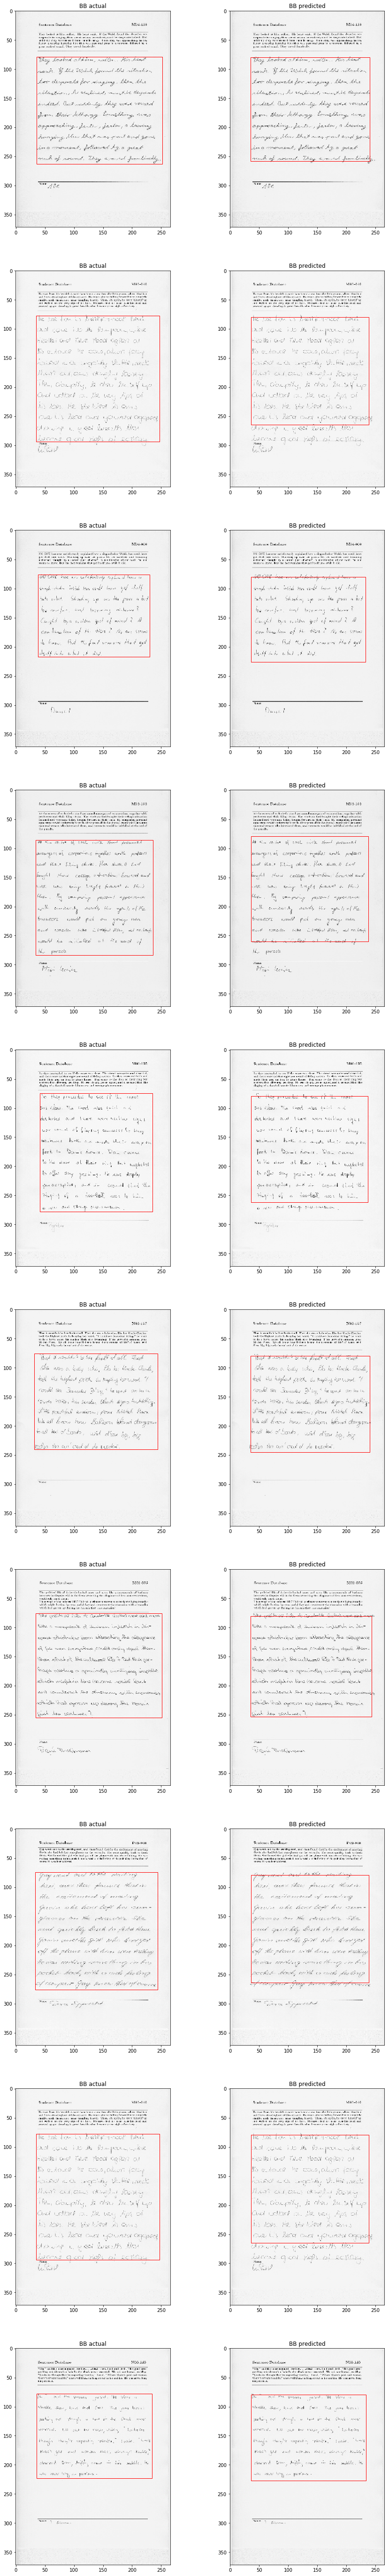

In [8]:
figs_to_plot = 10
fig, axs = plt.subplots(figs_to_plot, 2, figsize=(15, 10 * figs_to_plot))

for i in range(figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, bb = test_ds[n]

    image, _ = tf(image, bb)
    image = image.as_in_context(ctx)
    image = image.expand_dims(axis=0)
    bb_predicted = cnn(image)

    (x, y, w, h) = bb[0]
    axs[i][0].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[i][0].add_patch(rect)
    axs[i][0].set_title("BB actual")

    axs[i][1].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    (x, y, w, h) = bb_predicted[0].asnumpy()
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[i][1].add_patch(rect)
    axs[i][1].set_title("BB predicted")

Text(0.5,1,'BB predicted')

## Results
The training and test MSE is printed out in this notebook. The loss and the images with predicted bounding boxes is shown on [mxboard](https://medium.com/apache-mxnet/mxboard-mxnet-data-visualization-2eed6ae31d2c). 